In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import copy
import random

In [2]:
def visualize_graph(G):
    pos = nx.spring_layout(G)  # You can use other layouts as well

    # Draw edges
    nx.draw_networkx_edges(G, pos, edge_color='black', width=1.5)

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=700)

    # Draw node labels
    node_labels = {node: node for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)
    
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=8)

    plt.title("Graph Visualization")
    plt.show()

In [3]:
def generate_random_graph(node_count, connectivity):
    G = nx.Graph()

    # Add nodes to the graph
    G.add_nodes_from(range(1, node_count + 1))

    # Ensure at least min_edges are added for connectivity

    # Add edges to achieve the desired connectivity
    while len(list(nx.isolates(G))) >0:
        node1 = random.randint(1, node_count)
        node2 = random.randint(1, node_count)
        if node1 != node2 and not G.has_edge(node1, node2):
            G.add_edge(node1, node2)

    # Add remaining edges randomly
    remaining_edges = int(node_count * (node_count - 1) * connectivity / 2)
    for _ in range(remaining_edges):
        node1 = random.randint(1, node_count)
        node2 = random.randint(1, node_count)
        if node1 != node2 and not G.has_edge(node1, node2):
            G.add_edge(node1, node2)

    return G

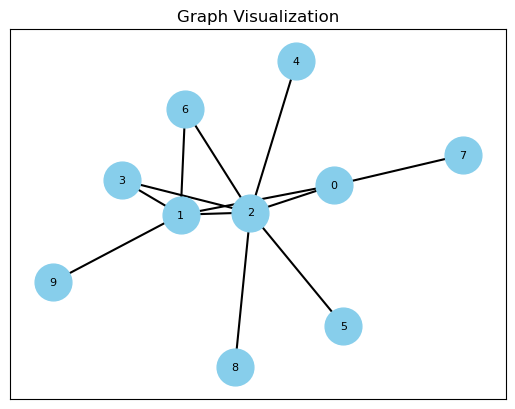

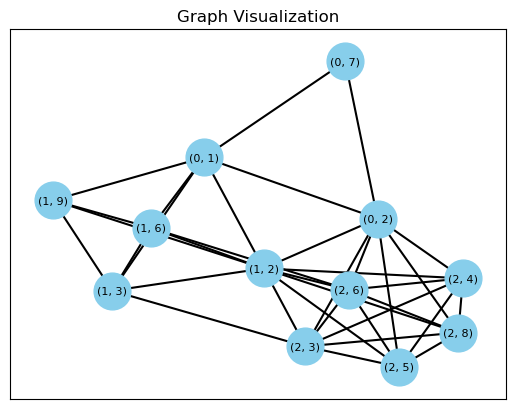

In [11]:
G = nx.scale_free_graph(n=10,alpha=.41).to_undirected()
G.remove_edges_from(list(nx.selfloop_edges(G)))
G = nx.Graph(G)
visualize_graph(G)
visualize_graph(nx.line_graph(G))

In [19]:
def generate_sf_graph(n):
    G = nx.scale_free_graph(n=n,alpha=.41).to_undirected()
    G.remove_edges_from(list(nx.selfloop_edges(G)))
    G = nx.Graph(G)
    G = nx.convert_node_labels_to_integers(G)
    components = list(nx.connected_components(G))
    while len(components) > 1:
        G.add_edge(components[0].pop(), components[1].pop())
        components = list(nx.connected_components(G))
    return G

In [15]:
def add_weights_to_edges_from_dict(graph, weights_dict):
    for edge, weight in weights_dict.items():
        if graph.has_edge(*edge):
            graph[edge[0]][edge[1]]['weight'] = np.sqrt( np.log(1/weight)) *10
        elif graph.has_edge(*reversed(edge)):
            graph[reversed(edge)[0]][reversed(edge)[1]]['weight'] = np.sqrt( np.log(1/weight)) *10
        else:
            print(f"Edge {edge} not found in the graph.")

In [12]:
PR = nx.pagerank(nx.line_graph(G),max_iter=100)
PR

{(2, 4): 0.08069356680142441,
 (2, 5): 0.08069356680142441,
 (0, 7): 0.036576813680988605,
 (2, 8): 0.08069356680142441,
 (1, 9): 0.060950189663707285,
 (1, 2): 0.13121991195557992,
 (1, 3): 0.07283604166264943,
 (1, 6): 0.07283604166264943,
 (0, 2): 0.10865745407547518,
 (2, 3): 0.09319128085310253,
 (2, 6): 0.09319128085310253,
 (0, 1): 0.08846028518847154}

In [14]:
add_weights_to_edges_from_dict(G,PR)

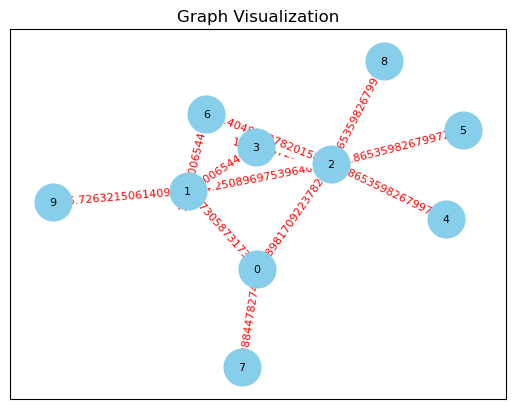

In [16]:

visualize_graph(G)

In [5]:
v_arr = np.array([])
r_arr = np.array([])

for i in range (1000):
    G = nx.scale_free_graph(n=10,alpha=.41).to_undirected()
    G.remove_edges_from(list(nx.selfloop_edges(G)))
    lg = nx.line_graph(G)
    pager = nx.pagerank(lg,max_iter=100)
    v_arr = np.append(v_arr,np.array(list(pager.values())))
    
    gr = generate_random_graph(10, 1)
    lg = nx.line_graph(gr)
    pager = nx.pagerank(lg,max_iter=100)
    r_arr = np.append(r_arr,np.array(list(pager.values())))
    

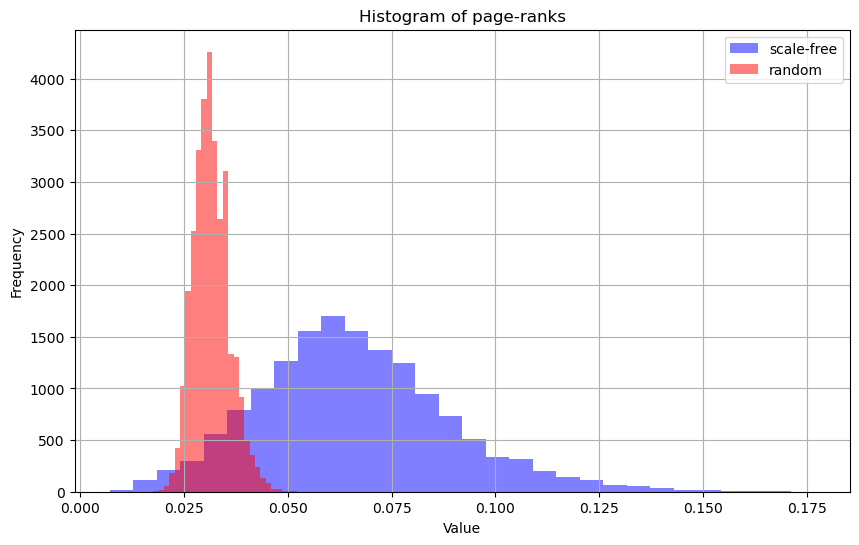

In [6]:
# Plotting histogram
plt.figure(figsize=(10, 6))

# Histogram for UN_walks
plt.hist(v_arr, bins=30, alpha=0.5, color='blue', label='scale-free')

# Histogram for PR_walks
plt.hist(r_arr, bins=30, alpha=0.5, color='red', label='random')

plt.title('Histogram of page-ranks')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

plt.show()


In [17]:
def probabilistic_walk(graph):
    visited_edges = set()
    walked_edges = []
    nodes = list(graph.nodes())
    
    current_node = random.choice(nodes)
    while len(visited_edges) < graph.number_of_edges():
        neighbors = list(graph.neighbors(current_node))
        weights = [graph[current_node][neighbor].get('weight', 1) for neighbor in neighbors]
        if len(weights) == 0:
            print("some fuckery")
            visualize_graph(graph)

        # Normalize weights to create probabilities
        try:
            probabilities = [weight / sum(weights) for weight in weights]
        except:
            print(weights)
            return
            

        next_node = random.choices(neighbors, weights=probabilities)[0]
        edge = (min(current_node, next_node), max(current_node, next_node))

        visited_edges.add(edge)
        walked_edges.append(edge)
        #print(f"Visited edge: {edge}")
        
        graph[current_node][next_node]['weight'] = np.sqrt(graph[current_node][next_node]['weight'])
        
        
        current_node = next_node

    return walked_edges

In [72]:
UN_walks = []
PR_walks = []
edge_count = []

for i in range(50,100):
    tmp_un = []
    tmp_pr = []
    tmp_e = []
    for j in range(10):
        G = generate_sf_graph(i)
        tmp_e.append(G.number_of_edges())
        L_G = nx.line_graph(G)
        PR = nx.pagerank(L_G,max_iter=i*10)
        UN = vertex_dict = {vertex: 0.001 for vertex in L_G.nodes()}

        U_G = copy.deepcopy(G)
        P_G = copy.deepcopy(G)
        add_weights_to_edges_from_dict(U_G,UN)
        add_weights_to_edges_from_dict(P_G,PR)
        u_tmp =[]
        for k in range(50):
            tmp=copy.deepcopy(U_G)
            u_tmp.append(len(probabilistic_walk(tmp)))
        pr_tmp = []
        for k in range(50):
            tmp=copy.deepcopy(P_G)
            pr_tmp.append(len(probabilistic_walk(tmp)))
        tmp_un.append(u_tmp)
        tmp_pr.append(pr_tmp)
    edge_count.append(tmp_e)
    UN_walks.append(tmp_un)
    PR_walks.append(tmp_pr)

In [67]:
print(edge_count)

[[11, 11, 10, 12, 11, 11, 10, 11, 11, 12], [11, 13, 13, 13, 17, 11, 14, 13, 11, 14], [14, 13, 13, 13, 14, 12, 14, 16, 12, 13], [14, 19, 13, 15, 15, 18, 15, 15, 15, 14], [18, 16, 15, 17, 18, 15, 20, 17, 15, 15], [22, 19, 18, 22, 17, 17, 20, 21, 16, 19], [17, 26, 17, 21, 18, 20, 19, 18, 18, 18], [24, 24, 21, 21, 18, 22, 17, 19, 23, 21], [21, 21, 22, 20, 22, 21, 21, 21, 26, 24], [25, 26, 25, 24, 23, 21, 23, 27, 24, 26], [26, 24, 28, 24, 25, 25, 27, 24, 28, 27], [27, 23, 23, 26, 23, 24, 25, 27, 27, 21], [27, 31, 28, 32, 24, 28, 26, 27, 35, 29], [27, 33, 24, 39, 27, 28, 35, 32, 31, 27], [28, 30, 31, 30, 28, 34, 33, 26, 30, 31], [38, 32, 34, 29, 30, 26, 31, 34, 35, 36], [37, 34, 36, 38, 32, 36, 31, 30, 31, 33], [36, 31, 33, 42, 28, 34, 41, 36, 38, 35], [34, 39, 34, 36, 41, 41, 38, 36, 38, 36], [47, 43, 44, 41, 33, 42, 39, 38, 43, 40], [41, 45, 45, 39, 42, 40, 40, 38, 41, 37], [37, 47, 39, 34, 49, 42, 43, 44, 42, 42], [42, 42, 39, 38, 41, 41, 40, 46, 46, 46], [44, 49, 50, 49, 46, 42, 40, 46, 

In [73]:
np_u = []
np_p = []
for i in range(len(UN_walks)):    
    tmp = np.concatenate(UN_walks[i])
    np_u.append(tmp)
    tmp = np.concatenate(PR_walks[i])
    np_p.append(tmp)
np_u = np.array(np_u)
np_p = np.array(np_p)
np_e = np.array(edge_count)
print(np_p)

[[166 364 162 ... 158 216 338]
 [247 224 287 ... 221 292 285]
 [186 201 183 ... 196 162 192]
 ...
 [541 450 571 ... 629 602 368]
 [462 399 402 ... 454 424 455]
 [593 678 438 ... 983 402 575]]


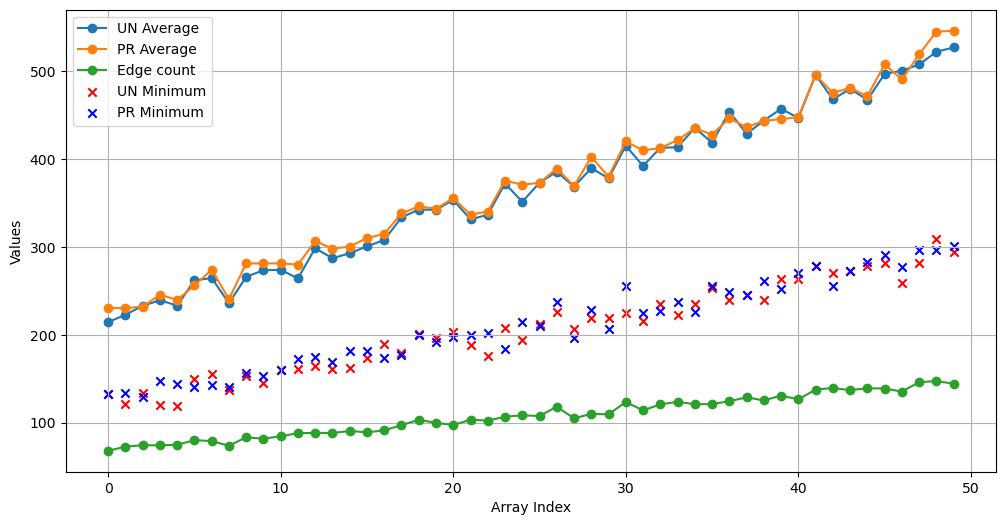

In [74]:



avg_r = np.mean(np_u,axis=1)
avg_p = np.mean(np_p,axis=1)

min_r = np.min(np_u,axis=1)
min_p = np.min(np_p,axis=1)

np_e = np.mean(np_e,axis=1)

plt.figure(figsize=(12, 6))

plt.plot( avg_r, label='UN Average', marker='o')
plt.plot( avg_p, label='PR Average', marker='o')
plt.plot( np_e, label='Edge count', marker='o')

# Plot minimums
plt.scatter(range(len(min_r)), min_r, color='red', label='UN Minimum', marker='x')
plt.scatter(range(len(min_p)), min_p, color='blue', label='PR Minimum', marker='x')

plt.xlabel('Array Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


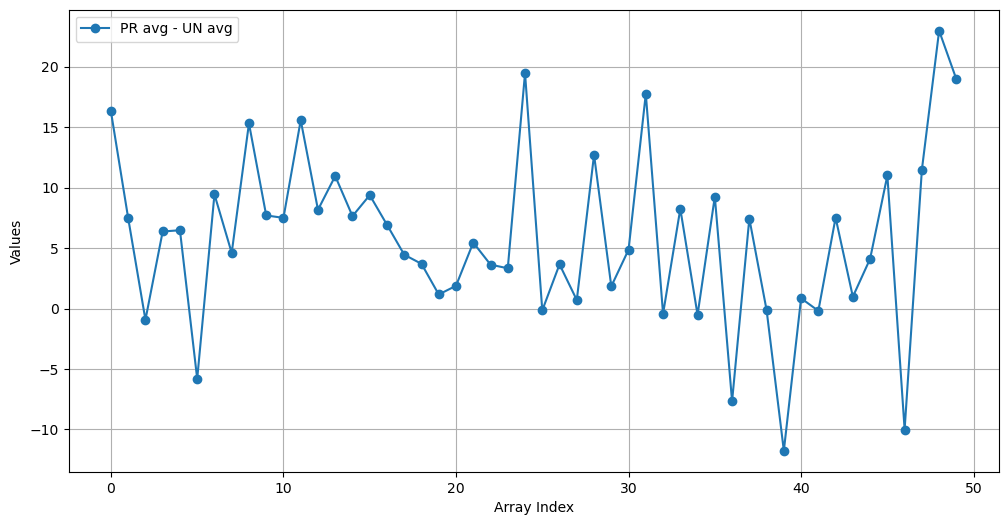

In [75]:
avg_diff = []
min_diff = []
for i in range(len(UN_walks)):
    avg_diff.append((np.average(np_p[i]) - np.average(np_u[i])))
    min_diff.append((min(np_p[i]) - min(np_u[i])))
    
plt.figure(figsize=(12, 6))

plt.plot( avg_diff, label='PR avg - UN avg', marker='o')
#plt.plot( min_diff, label='PR min - UN min', marker='o')

plt.xlabel('Array Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


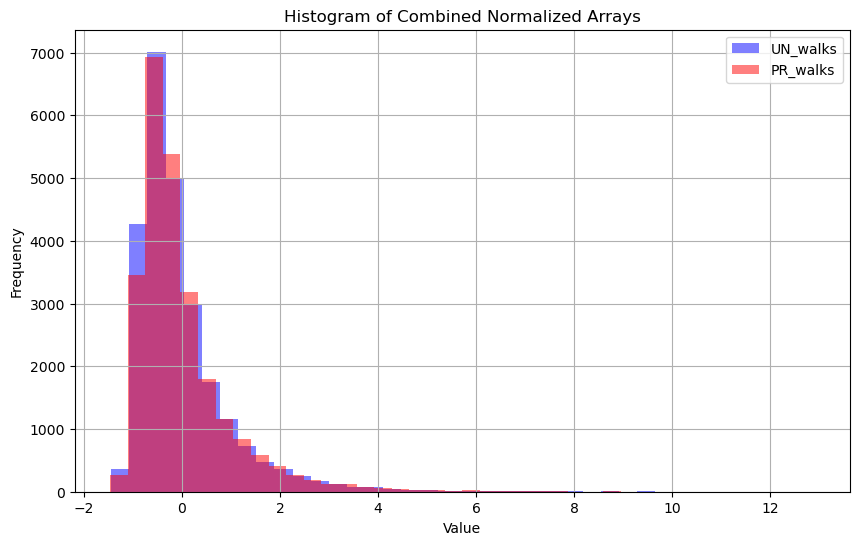

In [77]:
# Apply z-score normalization to each array individually for UN_walks
normalized_UN_walks = [(array - np.mean(array)) / np.std(array) for array in np_u]

# Apply z-score normalization to each array individually for PR_walks
normalized_PR_walks = [(array - np.mean(array)) / np.std(array) for array in np_p]

# Combine the normalized arrays into a single array
combined_normalized_array = np.concatenate(normalized_UN_walks + normalized_PR_walks)

# Plotting histogram
plt.figure(figsize=(10, 6))

# Histogram for UN_walks
plt.hist(np.concatenate(normalized_UN_walks), bins=30, alpha=0.5, color='blue', label='UN_walks')

# Histogram for PR_walks
plt.hist(np.concatenate(normalized_PR_walks), bins=40, alpha=0.5, color='red', label='PR_walks')

plt.title('Histogram of Combined Normalized Arrays')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

plt.show()